In [1]:
# The number of entries to read in. Use it to have fast turn-around
max_events = None
# Number on CV folds
n_cv = 5

import os
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)

import time
import gc
import copy

import mlflow
import mlflow.sklearn
from mlflow.entities import SourceType


import keggler as kg

from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, mean_squared_error, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, ElasticNetCV, SGDRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler

PATH = '/home/mlisovyi/.kaggle/competitions/santander-customer-transaction-prediction/'

print(os.listdir(PATH))

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df_trn = pd.read_csv(PATH+'train.csv')
df_tst = pd.read_csv(PATH+'test.csv')

In [4]:
df_trn = kg.reduce_mem_usage(df_trn, force_obj_in_category=False)
df_tst = kg.reduce_mem_usage(df_tst, force_obj_in_category=False)

Memory usage of dataframe is 319.76 MB
Memory usage after optimization is: 89.54 MB
Decreased by 72.0%
Memory usage of dataframe is 318.04 MB
Memory usage after optimization is: 89.16 MB
Decreased by 72.0%


In [5]:
df_trn.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.625000,-4.921875,5.746094,2.925781,3.181641,14.015625,0.574707,8.796875,14.570312,5.750000,-7.238281,4.285156,30.718750,10.531250,16.218750,2.578125,2.470703,14.382812,13.429688,-5.148438,-0.407227,4.929688,5.996094,-0.308594,12.906250,-3.876953,16.890625,11.195312,10.578125,0.676270,7.886719,4.667969,3.875000,-5.238281,7.375000,11.578125,12.046875,11.640625,-7.015625,5.921875,-14.210938,16.031250,5.324219,12.921875,29.046875,-0.693848,5.171875,-0.747559,14.835938,11.265625,5.382812,2.017578,10.117188,16.187500,4.960938,2.076172,-0.215454,8.671875,9.531250,5.804688,22.437500,5.011719,-4.699219,21.640625,0.566406,5.199219,8.859375,43.125000,18.375000,-2.343750,23.406250,6.519531,12.195312,13.648438,13.835938,1.367188,2.941406,-4.519531,21.468750,9.320312,16.453125,8.000000,-1.707031,-21.453125,6.781250,11.093750,9.992188,14.843750,0.181152,8.960938,16.25000,2.173828,-3.414062,9.476562,13.312500,26.531250,1.440430,14.710938,6.046875,9.539062,17.156250,14.109375,24.359375,2.033203,6.761719,3.914062,-0.485107,2.523438,1.509766,2.550781,15.578125,-13.421875,7.273438,16.015625,9.726562,0.889648,0.775391,4.222656,12.000000,13.859375,-0.733887,-1.924805,15.445312,12.828125,0.358643,9.648438,6.566406,5.171875,3.134766,29.453125,31.406250,2.828125,15.656250,8.328125,-5.601562,19.062500,11.265625,8.695312,8.367188,11.562500,-16.468750,4.027344,17.921875,18.515625,10.781250,9.007812,16.703125,10.484375,1.657227,12.171875,-13.132812,17.609375,11.539062,15.460938,5.312500,3.615234,5.039062,6.675781,12.664062,2.701172,-0.697266,9.601562,5.488281,-4.765625,-8.421875,20.875000,3.152344,18.562500,7.742188,-10.125000,13.726562,-3.519531,1.719727,-8.406250,9.015625,3.066406,14.367188,25.843750,5.875000,11.843750,-19.718750,17.578125,0.585938,4.433594,3.964844,3.136719,1.691406,18.515625,-2.398438,7.878906,8.562500,12.781250,-1.091797
1,train_1,0,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.531250,3.146484,8.085938,-0.403320,8.054688,14.023438,8.414062,5.433594,13.703125,13.828125,-15.585938,7.800781,28.578125,3.427734,2.740234,8.554688,3.371094,6.976562,13.890625,-11.765625,-2.558594,5.046875,0.548340,-9.296875,7.875000,1.286133,19.375000,11.367188,0.739746,2.798828,5.843750,10.812500,3.677734,-11.117188,1.873047,9.875000,11.781250,1.244141,-47.375000,7.371094,0.194824,34.406250,25.703125,11.835938,13.226562,-4.109375,6.687500,-8.093750,18.593750,19.328125,7.011719

# FE

In [6]:
from sklearn.neighbors import KNeighborsClassifier

def apply_fe(df, ss=None, mm=None, knn_dict={}):
    cols = [c for c in df.columns if 'var_' in c]
    df_out = df.copy(deep=True)
    if ss:
        df_ss = ss.transform(df[cols])        
#         if not knn_dict:
#             for i in [50]:
#                 t = time.time()
#                 knn_dict[i] = KNeighborsClassifier(i, n_jobs=4).fit(df_ss, df['target'])
#                 print('Trained KNN{} in {:.2f} sec'.format(i, time.time()-t))
#         for name,knn in knn_dict.items():
#             t = time.time()
#             df_out['knn_{}'.format(name)] = knn.predict_proba(df_ss)[:,1]
#             print('Applied KNN{} in {:.2f} sec'.format(name, time.time()-t))
#         for i in range(1,5):
#             df_out['n_sigma{}'.format(i)] = (df_ss >= i).sum(axis=1)
#         df_out['sum_sigmas'] = df_ss.sum(axis=1)
        del df_ss
        
#     if mm:
#         df_mm = mm.transform(df[cols])
#         df_out['sum_mm'] = df_mm.sum(axis=1)        
#         del df_mm
    
    return df_out, knn_dict

In [7]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
ss = StandardScaler().fit(df_trn.iloc[:,2:])
mm = MinMaxScaler().fit(df_trn.iloc[:,2:])

df_trn, knn = apply_fe(df_trn.iloc[:,:], ss=ss, mm=mm, knn_dict={})
df_tst, _ = apply_fe(df_tst, ss=ss, mm=mm, knn_dict=knn)

In [8]:
df_trn.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.921875,-6.785156,11.906250,5.093750,11.460938,-9.281250,5.117188,18.625000,-4.921875,5.746094,2.925781,3.181641,14.015625,0.574707,8.796875,14.570312,5.750000,-7.238281,4.285156,30.718750,10.531250,16.218750,2.578125,2.470703,14.382812,13.429688,-5.148438,-0.407227,4.929688,5.996094,-0.308594,12.906250,-3.876953,16.890625,11.195312,10.578125,0.676270,7.886719,4.667969,3.875000,-5.238281,7.375000,11.578125,12.046875,11.640625,-7.015625,5.921875,-14.210938,16.031250,5.324219,12.921875,29.046875,-0.693848,5.171875,-0.747559,14.835938,11.265625,5.382812,2.017578,10.117188,16.187500,4.960938,2.076172,-0.215454,8.671875,9.531250,5.804688,22.437500,5.011719,-4.699219,21.640625,0.566406,5.199219,8.859375,43.125000,18.375000,-2.343750,23.406250,6.519531,12.195312,13.648438,13.835938,1.367188,2.941406,-4.519531,21.468750,9.320312,16.453125,8.000000,-1.707031,-21.453125,6.781250,11.093750,9.992188,14.843750,0.181152,8.960938,16.25000,2.173828,-3.414062,9.476562,13.312500,26.531250,1.440430,14.710938,6.046875,9.539062,17.156250,14.109375,24.359375,2.033203,6.761719,3.914062,-0.485107,2.523438,1.509766,2.550781,15.578125,-13.421875,7.273438,16.015625,9.726562,0.889648,0.775391,4.222656,12.000000,13.859375,-0.733887,-1.924805,15.445312,12.828125,0.358643,9.648438,6.566406,5.171875,3.134766,29.453125,31.406250,2.828125,15.656250,8.328125,-5.601562,19.062500,11.265625,8.695312,8.367188,11.562500,-16.468750,4.027344,17.921875,18.515625,10.781250,9.007812,16.703125,10.484375,1.657227,12.171875,-13.132812,17.609375,11.539062,15.460938,5.312500,3.615234,5.039062,6.675781,12.664062,2.701172,-0.697266,9.601562,5.488281,-4.765625,-8.421875,20.875000,3.152344,18.562500,7.742188,-10.125000,13.726562,-3.519531,1.719727,-8.406250,9.015625,3.066406,14.367188,25.843750,5.875000,11.843750,-19.718750,17.578125,0.585938,4.433594,3.964844,3.136719,1.691406,18.515625,-2.398438,7.878906,8.562500,12.781250,-1.091797
1,train_1,0,11.500000,-4.148438,13.859375,5.390625,12.359375,7.042969,5.621094,16.531250,3.146484,8.085938,-0.403320,8.054688,14.023438,8.414062,5.433594,13.703125,13.828125,-15.585938,7.800781,28.578125,3.427734,2.740234,8.554688,3.371094,6.976562,13.890625,-11.765625,-2.558594,5.046875,0.548340,-9.296875,7.875000,1.286133,19.375000,11.367188,0.739746,2.798828,5.843750,10.812500,3.677734,-11.117188,1.873047,9.875000,11.781250,1.244141,-47.375000,7.371094,0.194824,34.406250,25.703125,11.835938,13.226562,-4.109375,6.687500,-8.093750,18.593750,19.328125,7.011719

# Training

In [9]:
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.base import clone, ClassifierMixin, RegressorMixin
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import time


def train_single_model(clf_, X_, y_, random_state_=314, opt_parameters_={}, fit_params_={}):
    '''
    A wrapper to train a model with particular parameters
    '''
    c = clone(clf_)
    c.set_params(**opt_parameters_)
    c.set_params(random_state=random_state_)
    return c.fit(X_, y_, **fit_params_)

def train_model_in_CV(model, X, y, metric, metric_args={},
                            model_name='xmodel',
                            seed=31416, n=5,
                            opt_parameters_={}, fit_params_={},
                            verbose=True,
                            groups=None, y_eval=None,
                            mlf=None, mlf_metric_name=None
                     ):
    # the list of classifiers for voting ensable
    clfs = []
    # performance 
    perf_eval = {'score_i_oof': 0,
                 'score_i_ave': 0,
                 'score_i_std': 0,
                 'score_i': [],
                 'fit_time': []
                }
    # full-sample oof prediction
    y_full_oof = pd.Series(np.zeros(shape=(y.shape[0],)), 
                          index=y.index)
    
    sample_weight=None
    if 'sample_weight' in metric_args:
        sample_weight=metric_args['sample_weight']
        
    index_weight=None
    if 'index_weight' in metric_args:
        index_weight=metric_args['index_weight']
        del metric_args['index_weight']
        
    doSqrt=False
    if 'sqrt' in metric_args:
        doSqrt=True
        del metric_args['sqrt']

    if groups is None:
        cv = StratifiedKFold(n, shuffle=True, random_state=seed) #Stratified
    else:
        cv = GroupKFold(n)
    # The out-of-fold (oof) prediction for the k-1 sample in the outer CV loop
    y_oof = pd.Series(np.zeros(shape=(X.shape[0],)), 
                      index=X.index)
    scores = []
    clfs = []
    feature_importances = []

    for n_fold, (trn_idx, val_idx) in enumerate(cv.split(X, (y!=0).astype(np.int8), groups=groups)):
        X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        if 'LGBMRanker' in type(model).__name__ and groups is not None:
            G_trn, G_val = groups.iloc[trn_idx], groups.iloc[val_idx]        

        if fit_params_:
            # use _stp data for early stopping
            fit_params_["eval_set"] = [(X_trn,y_trn), (X_val,y_val)]
            fit_params_['verbose'] = verbose
            if index_weight is not None:
                fit_params_["sample_weight"] = y_trn.index.map(index_weight).values
                fit_params_["eval_sample_weight"] = [None, y_val.index.map(index_weight).values]
            if 'LGBMRanker' in type(model).__name__ and groups is not None:
                fit_params_['group'] = G_trn.groupby(G_trn, sort=False).count()
                fit_params_['eval_group'] = [G_trn.groupby(G_trn, sort=False).count(),
                                             G_val.groupby(G_val, sort=False).count()]

        #display(y_trn.head())
        t = time.time()
        clf = train_single_model(model, X_trn, y_trn, 314+n_fold, opt_parameters_, fit_params_)
        perf_eval['fit_time'].append(time.time()-t)

        clfs.append(('{}{}'.format(model_name,n_fold), clf))
        # oof predictions
        if isinstance(clf, RegressorMixin):
            y_oof.iloc[val_idx] = clf.predict(X_val)
        elif isinstance(clf, ClassifierMixin):
            y_oof.iloc[val_idx] = clf.predict_proba(X_val)[:,1]
        else:
            y_oof.iloc[val_idx] = clf.predict(X_val)
        # prepare weights for evaluation
        if sample_weight is not None:
            metric_args['sample_weight'] = y_val.map(sample_weight)
        elif index_weight is not None:
            metric_args['sample_weight'] = y_val.index.map(index_weight).values
        # prepare target values
        y_true_tmp = y_val if 'LGBMRanker' not in type(model).__name__  and y_eval is None else y_eval.iloc[val_idx]
        y_pred_tmp = y_oof.iloc[val_idx] if y_eval is None else y_oof.iloc[val_idx]        
        #store evaluated metric
        metric_value = metric(y_true_tmp, y_pred_tmp, **metric_args)
        scores.append(metric_value)
        if mlf is not None:
            mlf.log_metric("{}_Fold{}".format(mlf_metric_name, n_fold), metric_value)
        #
        fi_tmp = pd.DataFrame()
        fi_tmp["feature"] = X.columns
        if hasattr(clf, 'feature_importances_'):
            fi_tmp["importance"] = clf.feature_importances_
        fi_tmp["fold"] = n_fold + 1
        feature_importances.append(fi_tmp)
        #cleanup
        del X_trn, y_trn, X_val, y_val, y_true_tmp, y_pred_tmp

    # Store performance info for this CV
    if sample_weight is not None:
        metric_args['sample_weight'] = y_oof.map(sample_weight)
    elif index_weight is not None:
        metric_args['sample_weight'] = y_oof.index.map(index_weight).values
    perf_eval['score_i_oof'] = metric(y, y_oof, **metric_args)
    perf_eval['score_i'] = scores
    
    if doSqrt:
        for k in perf_eval.keys():
            if 'score' in k:
                perf_eval[k] = np.sqrt(perf_eval[k])
        scores = np.sqrt(scores)
            
    perf_eval['score_i_ave'] = np.mean(scores)
    perf_eval['score_i_std'] = np.std(scores)

    return clfs, perf_eval, y_oof, pd.concat(feature_importances, axis=0)

def print_perf_clf(name, perf_eval):
    print('Performance of the model:')    
    print('Mean(Val) score inner {} Classifier: {:.4f}+-{:.4f}'.format(name, 
                                                                      perf_eval['score_i_ave'],
                                                                      perf_eval['score_i_std']
                                                                     ))
    print('Min/max scores on folds: {:.4f} / {:.4f}'.format(np.min(perf_eval['score_i']),
                                                            np.max(perf_eval['score_i'])))
    print('OOF score inner {} Classifier: {:.4f}'.format(name, perf_eval['score_i_oof']))
    print('Scores in individual folds: {}'.format(['{:.4f}'.format(x) for x in perf_eval['score_i']]))

In [10]:
def learning_rate_decay_power(current_iter):
    '''
    The function defines learning rate deay for LGBM
    '''
    base_learning_rate = 1e-1
    min_lr = 1e-2
    lr = base_learning_rate  * np.power(.95, current_iter)
    return lr if lr > min_lr else min_lr

def learning_rate_steps_5k(current_iter):
    '''
    The function defines learning rate deay for LGBM
    '''
    period = 5000
    return 1e-2 / (1 + current_iter//period)

learning_rate_decay_power(1000)

0.01

In [13]:
mdl_inputs = {
    'lgbm_base': (
        lgb.LGBMClassifier(
            max_depth=-1,
            min_child_samples=40,
            random_state=314,
            silent=True,
            metric='None',
            n_jobs=4,
            n_estimators=25000,
            importance_type='gain'),
        {
            'colsample_bytree': 0.02,
            'subsample': 0.05,
            'min_child_weight': 100.0,
            'min_child_samples': 100,
            'learning_rate': 0.005,
            'num_leaves': 25,
#             'class_weight': 'balanced'
        },
#         {
#             'colsample_bytree': 0.05,
#             'subsample': 0.05,
#             'min_child_weight': 100.0,
#             'min_child_samples': 100,
#             'learning_rate': 0.01,
#             'num_leaves': 15,
# #             'scale_pos_weight': 0.3,
# #             'reg_alpha': 0,
# #             'reg_lambda': 50,
# #             'class_weight': 'balanced'
#         },
        {
            "early_stopping_rounds": 1000,
            "eval_metric": 'auc',
#             'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_steps_5k)],
#             'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
        },
        df_trn['target'],
        None),
#         'lgbm_rf': (lgb.LGBMClassifier(boosting_type='rf', reg_lambda=0, #min_child_samples=400, 
#                          max_depth=-1, random_state=314, silent=True, metric='None', 
#                          n_jobs=4, bagging_freq=1, importance_type='gain'),
#                {'colsample_bytree': 0.05, 'min_child_samples': 300, 'min_child_weight': 100, 
#                   'num_leaves': 100, 'subsample': 0.2, 'n_estimators':1500,}, 
#                {},
#                df_trn['target'],
#             None),
}

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test = {
    'num_leaves': [7, 15, 25, 70],#sp_randint(6, 100),
#     'min_child_samples': [100,300,500,700,900],#sp_randint(100, 1000),
    'min_child_weight': [10,100],#[1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': [0.1, 0.15, 0.2, 0.4],#sp_uniform(loc=0.5, scale=0.5),
    'colsample_bytree': [0.02,0.05,0.1],#[0.35,0.50,0.65,0.75,0.85,0.95],#sp_uniform(loc=0.5, scale=0.5),
#     'reg_alpha': [0, 1e-1],
#     'reg_lambda': [0, 1e-3, 1e-1, 1]
}

from sklearn.model_selection import ParameterSampler, ParameterGrid
par_sampler = ParameterSampler(param_test, n_iter=2, random_state=31416)

par_grid = ParameterGrid([#{'colsample_bytree':[0.035,0.065]},
                          #{'subsample': [0.1, 0.15, 0.25, 0.3, 0.4]}
                          {'n_estimators': [4000, 8000]}
                         ])

features_not2use = ['ID_code', 'target']

In [12]:
# for v in ['var_89', 'var_139', 'var_12', 'var_81']:
#     kg.plot_var_for2classes(df_trn, v, bins=50,
#                             target_name='target')
#     plt.title(v)

### Hyper-parameter optimisation

--------------- lgbm_base -----------
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.893961	valid_1's auc: 0.874072
[4000]	training's auc: 0.917147	valid_1's auc: 0.88836
[6000]	training's auc: 0.929889	valid_1's auc: 0.894898
[8000]	training's auc: 0.93826	valid_1's auc: 0.89824
[10000]	training's auc: 0.944614	valid_1's auc: 0.899907
[12000]	training's auc: 0.950071	valid_1's auc: 0.900662
[14000]	training's auc: 0.95505	valid_1's auc: 0.901063
[16000]	training's auc: 0.959597	valid_1's auc: 0.90119
[18000]	training's auc: 0.963753	valid_1's auc: 0.90127
[20000]	training's auc: 0.967584	valid_1's auc: 0.901323
[22000]	training's auc: 0.971056	valid_1's auc: 0.90134
Early stopping, best iteration is:
[21270]	training's auc: 0.969818	valid_1's auc: 0.901365
Training until validation scores don't improve for 1000 rounds.
[2000]	training's auc: 0.894929	valid_1's auc: 0.871847
[4000]	training's auc: 0.91747	valid_1's auc: 0.886087
[6000]	training

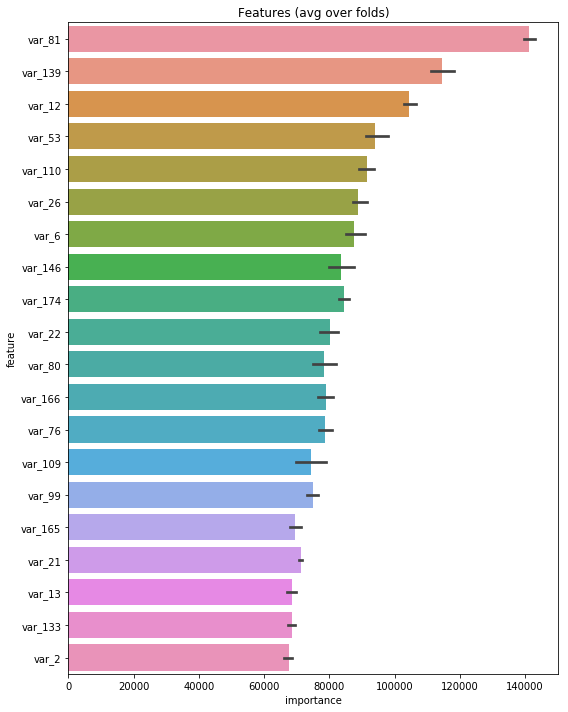

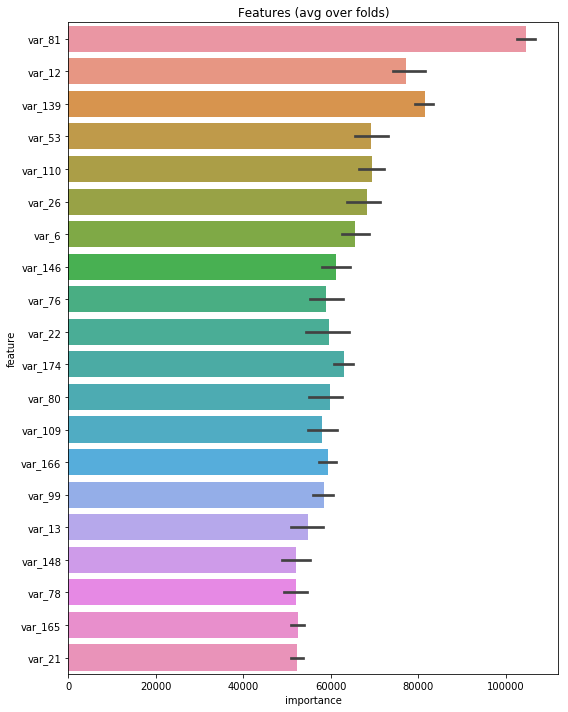

In [14]:
feats = [c for c in df_trn.columns if c not in features_not2use]

n_trn = None
seed_cv = 31416

mdls = {}
results = {}
y_oofs = {}
fis = {}  # feature importances

mlflow.set_experiment('TMP')

for name, (mdl, mdl_pars, fit_pars, y_, g_) in mdl_inputs.items():
    for ps in par_sampler: # par_sampler
        mdl_pars_ = copy.deepcopy(mdl_pars)
        mdl_pars_.update(ps)
        with mlflow.start_run(source_type=SourceType.NOTEBOOK, 
                              source_version=kg.get_last_git_commit()):
            print('--------------- {} -----------'.format(name))
            mlflow.set_tag('model_name', name)
            # Logging
            for k, v in mdl_pars_.items():
                mlflow.log_param(k, v)
            if n_trn is not None:
                mlflow.log_param('n_trn', n_trn)
            mlflow.log_param('seed_cv', seed_cv)

            mdl_, perf_eval_, y_oof_, fi_ = train_model_in_CV(
                mdl,
                df_trn[feats].iloc[:n_trn, :],
                y_.iloc[:n_trn],
                roc_auc_score,
                metric_args={},
                model_name=name,
                opt_parameters_=mdl_pars_,
                fit_params_=fit_pars,
                n=n_cv,
                seed=seed_cv,
                verbose=2000, groups=g_,
                mlf=mlflow, mlf_metric_name='AUC'
            )
            results[name] = perf_eval_
            mdls[name] = mdl_
            y_oofs[name] = y_oof_
            fis[name] = fi_
            print_perf_clf(name, perf_eval_)

            # metrics
            mlflow.log_metric("AUC", perf_eval_['score_i_ave'])
            mlflow.log_metric("AUC_STD", perf_eval_['score_i_std'])
#             for i in range(n_cv):
#                 m = mdls['lgbm_base'][i][1]
#                 for j in range(m.best_iteration_):
#                     mlflow.log_metric("AUC_Fold{}".format(i), m.evals_result_['valid_1']['auc'][j])
            fit_time_ave = np.mean(perf_eval_['fit_time'])
            if hasattr(mdl_[0][1],'n_estimators'):
                n_trees_ave = np.nanmean([m[1].n_estimators for m in mdl_])
            if getattr(mdl_[0][1], 'best_iteration_', None) is not None:
                n_trees_ave = np.nanmean([m[1].best_iteration_ for m in mdl_])    
            mlflow.log_metric('Time_sec', fit_time_ave)
            mlflow.log_metric('N_trees', n_trees_ave)
            mlflow.log_metric('Time_per_tree_msec', fit_time_ave / n_trees_ave * 1000)
            # artifacts
            # OOF
            y_oof_.to_csv('out/oof.csv', index=False)
            mlflow.log_artifact(os.getcwd()+'/out/oof.csv')
            # Submission
            sub = pd.DataFrame(index=df_tst['ID_code'])
            sub['target'] = 0
            for n, m in mdl_:
                sub['target'] += m.predict_proba(df_tst[feats])[:,1]/n_cv
            sub.to_csv('out/sub.csv', index=False)
            mlflow.log_artifact(os.getcwd()+'/out/sub.csv')
            #
            for v in fis:
                kg.display_importances(fis[v], n_feat=20, fout_name='out/fi.png')
                mlflow.log_artifact(os.getcwd()+'/out/fi.png')

### Single model run

In [16]:
feats = [c for c in df_trn.columns if c not in features_not2use]

n_trn = None#-100000
n_ho = None
seed_cv = 31416

mdls = {}
results = {}
y_oofs = {}
fis = {}  # feature importances

mlflow.set_experiment('TMP')

for name, (mdl, mdl_pars, fit_pars, y_, g_) in mdl_inputs.items():
    mdl_pars_ = copy.deepcopy(mdl_pars)
    with mlflow.start_run(source_type=SourceType.NOTEBOOK,
                          source_version=kg.get_last_git_commit()):
        print('--------------- {} -----------'.format(name))
        mlflow.set_tag('model_name', name)
        # Logging
        for k, v in mdl_pars_.items():
            mlflow.log_param(k, v)
        if n_trn is not None:
            mlflow.log_param('n_trn', n_trn)
        mlflow.log_param('seed_cv', seed_cv)

        mdl_, perf_eval_, y_oof_, fi_ = train_model_in_CV(mdl,
            df_trn[feats].iloc[:n_trn, :], y_.iloc[:n_trn],
            roc_auc_score,
            metric_args={},
            model_name=name,
            opt_parameters_=mdl_pars_,
            fit_params_=fit_pars,
            n=n_cv, seed=seed_cv,
            verbose=500, groups=g_,
            mlf=mlflow, mlf_metric_name='AUC')
        results[name] = perf_eval_
        mdls[name] = mdl_
        y_oofs[name] = y_oof_
        fis[name] = fi_
        print_perf_clf(name, perf_eval_)

        # metrics
        mlflow.log_metric("AUC", perf_eval_['score_i_ave'])
        mlflow.log_metric("AUC_STD", perf_eval_['score_i_std'])
#             for i in range(n_cv):
#                 m = mdls['lgbm_base'][i][1]
#                 for j in range(m.best_iteration_):
#                     mlflow.log_metric("AUC_Fold{}".format(i), m.evals_result_['valid_1']['auc'][j])
        fit_time_ave = np.mean(perf_eval_['fit_time'])
        if hasattr(mdl_[0][1],'n_estimators'):
            n_trees_ave = np.nanmean([m[1].n_estimators for m in mdl_])
        if getattr(mdl_[0][1], 'best_iteration_', None) is not None:
            n_trees_ave = np.nanmean([m[1].best_iteration_ for m in mdl_])
        mlflow.log_metric('Time_sec', fit_time_ave)
        mlflow.log_metric('N_trees', n_trees_ave)
        mlflow.log_metric('Time_per_tree_sec', fit_time_ave / n_trees_ave * 1000)
#         # artifacts
#         # OOF
#         y_oof_.to_csv('out/oof.csv', index=False)
#         mlflow.log_artifact(os.getcwd()+'/out/oof.csv')
#         # Submission
#         sub = pd.DataFrame(index=df_tst['ID_code'])
#         sub['target'] = 0
#         for n, m in mdl_:
#             sub['target'] += m.predict_proba(df_tst[feats])[:,1]/n_cv
#         sub.to_csv('out/sub.csv', index=False)
#         mlflow.log_artifact(os.getcwd()+'/out/sub.csv')
#         #
#         kg.display_importances(fis['lgbm_base'], n_feat=20, fout_name='out/fi.png')
#         mlflow.log_artifact(os.getcwd()+'/out/fi.png')

--------------- lgbm_base -----------
Training until validation scores don't improve for 1000 rounds.
[500]	training's auc: 0.914378	valid_1's auc: 0.888474
[1000]	training's auc: 0.923221	valid_1's auc: 0.895646
[1500]	training's auc: 0.92621	valid_1's auc: 0.897689
[2000]	training's auc: 0.928884	valid_1's auc: 0.899411
[2500]	training's auc: 0.930457	valid_1's auc: 0.899814
[3000]	training's auc: 0.932074	valid_1's auc: 0.900464
[3500]	training's auc: 0.933625	valid_1's auc: 0.901121
[4000]	training's auc: 0.934986	valid_1's auc: 0.901285
[4500]	training's auc: 0.93631	valid_1's auc: 0.901406
[5000]	training's auc: 0.937582	valid_1's auc: 0.901503
[5500]	training's auc: 0.938794	valid_1's auc: 0.90168
[6000]	training's auc: 0.940001	valid_1's auc: 0.901951
[6500]	training's auc: 0.941143	valid_1's auc: 0.901997
[7000]	training's auc: 0.942167	valid_1's auc: 0.902046
[7500]	training's auc: 0.943302	valid_1's auc: 0.902095
[8000]	training's auc: 0.944374	valid_1's auc: 0.902114
[8500]

In [21]:
# oof's for different targets
oof_0 = y_oofs['lgbm_base'][df_trn['target']==0]
oof_1 = y_oofs['lgbm_base'][df_trn['target']==1]
# ranked oof's for different targets
oof_rnk_0 = y_oofs['lgbm_base'].rank(pct=True)[df_trn['target']==0]
oof_rnk_1 = y_oofs['lgbm_base'].rank(pct=True)[df_trn['target']==1]

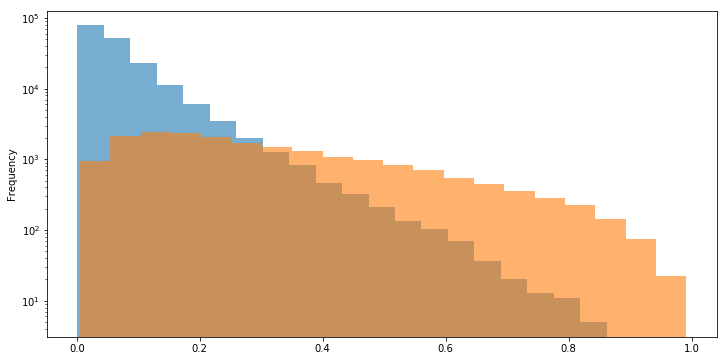

In [22]:
plt.figure(figsize=(12,6))
oof_0.plot.hist(bins=20, alpha=0.6)
oof_1.plot.hist(bins=20, alpha=0.6)
plt.yscale('log')

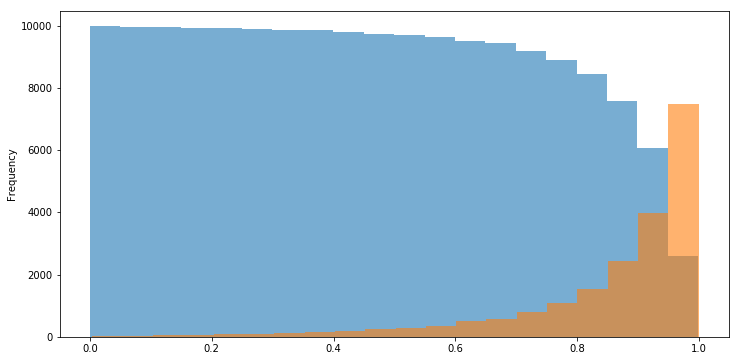

In [26]:
plt.figure(figsize=(12,6))
oof_rnk_0.plot.hist(bins=20, alpha=0.6)
oof_rnk_1.plot.hist(bins=20, alpha=0.6)
#plt.yscale('log')

In [28]:
oof_rnk_0.nlargest(10)

3073      0.999125
155311    0.999105
57788     0.999010
40008     0.998940
39656     0.998700
68789     0.998140
103419    0.998130
107285    0.998110
58770     0.997645
95474     0.997640
dtype: float64

In [29]:
oof_rnk_1.nlargest(10)

90698     1.000000
2320      0.999995
79322     0.999990
37353     0.999985
53965     0.999980
98469     0.999975
106837    0.999970
173406    0.999965
114931    0.999960
24050     0.999955
dtype: float64

In [31]:
df_trn.loc[oof_rnk_0.nlargest(10).index]

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
3073,train_3073,0,10.125000,7.546875,11.085938,4.070312,10.671875,-18.546875,7.664062,19.609375,-2.904297,6.949219,1.817383,-10.007812,13.859375,-1.770508,10.421875,15.054688,5.433594,-11.351562,23.828125,5.808594,11.382812,5.023438,7.542969,3.580078,16.093750,13.914062,3.781250,-3.515625,4.550781,5.261719,-9.765625,12.554688,-0.665527,12.289062,10.539062,1.019531,-1.093750,5.582031,3.462891,-1.841797,8.085938,11.671875,11.515625,11.203125,18.734375,6.359375,14.273438,-20.765625,7.847656,6.687500,12.296875,6.675781,-7.109375,7.675781,2.986328,15.406250,16.765625,6.335938,1.897461,7.695312,9.359375,-19.640625,3.890625,-3.785156,7.078125,6.628906,5.847656,26.187500,5.027344,-0.281738,32.656250,0.983398,-4.238281,14.046875,16.312500,12.382812,3.861328,19.343750,4.703125,13.335938,-7.644531,14.367188,-11.000000,10.929688,-3.265625,25.421875,13.718750,5.261719,6.292969,2.048828,-20.921875,7.085938,9.953125,9.718750,7.503906,-0.178955,25.109375,30.781250,1.398438,3.578125,-10.500000,11.781250,22.718750,1.875977,13.078125,3.095703,9.195312,31.328125,14.390625,8.625000,4.433594,7.691406,1.634766,7.265625,2.158203,-2.021484,0.361084,12.531250,-0.575195,6.109375,3.199219,10.257812,7.914062,8.015625,9.632812,13.171875,14.695312,3.769531,0.633789,18.453125,12.750000,0.614258,8.296875,6.214844,-4.871094,1.826172,24.375000,14.867188,-1.960938,3.541016,4.617188,-1.598633,3.654297,14.804688,8.054688,7.082031,9.992188,-1.195312,3.539062,-2.982422,14.265625,10.492188,12.414062,21.125000,10.359375,-3.814453,13.507812,-2.039062,5.261719,7.574219,21.109375,5.804688,8.171875,-2.734375,-0.867188,28.125000,3.128906,-0.389893,7.335938,5.218750,-1.745117,-5.472656,21.250000,6.500000,27.125000,9.492188,-11.390625,14.593750,1.431641,5.980469,-6.058594,9.710938,-3.275391,13.687500,15.953125,-6.910156,5.335938,4.027344,6.703125,-0.134766,-4.433594,7.667969,1.352539,4.945312,23.281250,-0.725098,-5.593750,8.570312,18.203125,6.558594
155311,train_155311,0,9.945312,1.412109,13.820312,9.421875,12.171875,0.285400,5.914062,16.531250,1.370117,7.785156,2.457031,-7.617188,13.796875,13.789062,10.257812,14.390625,8.679688,-11.679688,32.531250,15.304688,21.890625,19.968750,1.582031,3.740234,11.484375,13.468750,11.281250,0.428711,6.089844,8.593750,-4.343750,10.953125,0.011398,14.710938,11.351562,8.859375,2.666016,7.449219,17.875000,6.488281,10.429688,15.625000,11.609375,11.250000,9.437500,6.683594,10.968750,-2.816406,28.421875,26.296875,12.515625,17.687500,-4.703125,5.792969,-5.226562,20.50000

In [ ]:
df_trn.loc[oof_rnk_0.nlargest(10).index]

In [32]:
oof_0.shape

(179902,)

In [33]:
oof_1.shape

(20098,)

# Importances

## SHAP

In [34]:
import shap
shap.initjs()

In [37]:
n_shap=10000
explainer = shap.TreeExplainer(mdls['lgbm_base'][0][1])
shap_values = explainer.shap_values(df_trn[feats].iloc[:n_shap,:])

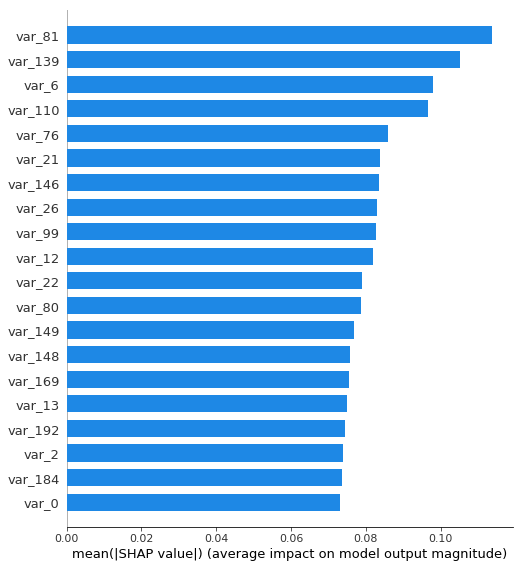

In [38]:
shap.summary_plot(shap_values, df_trn[feats].iloc[:n_shap,:], plot_type="bar")